In [6]:
import pandas as pd
import numpy as np
import spiro.data_preprocessing
from spiro.models import *
from spiro.learners import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import random
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from tqdm import tqdm
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import copy



# Setting the seed for reproducibility

np.random.seed(0)
random.seed(0)

import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import probml_utils as pml
import seaborn as sns
import pathlib

In [7]:
import warnings
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings(action="ignore", category=DataConversionWarning)

In [8]:
data_dir = pathlib.Path(os.getcwd()).parents[0].joinpath('data')
fig_dir = str(pathlib.Path(os.getcwd()).parents[0].joinpath('figures'))

In [9]:
os.environ['LATEXIFY'] = '1'
os.environ['FIG_DIR'] = fig_dir

p = plt.rcParams

# Grid Setting
p["grid.color"] = "#999999"
p["grid.linestyle"] = "--"

# Markersize setting for scatter
if pml.is_latexify_enabled():
    p["lines.markersize"] = 5
    p["lines.markeredgewidth"] = 1.5
    p["lines.linewidth"] = 2
    p["grid.linewidth"] = 0.5
else:
    p["lines.markersize"] = 5
    p["lines.markeredgewidth"] = 1.5
    p["lines.linewidth"] = 2

In [10]:
data = pd.read_csv("../data/feature_30_joint_51.csv")
data2 = pd.DataFrame(np.load("../data/Final_features_3k5k_order5_53.npy",allow_pickle=True))

In [11]:
data= data[~data.iloc[:,0].isin([21,48])].reset_index(drop=True)

In [12]:
data.drop("Unnamed: 0",axis=1,inplace=True)

In [13]:
remove = ['P1', 'P11', 'P22', 'P22', 'P25', 'P37', 'P4', 'P47', 'P48', 'P49', 'P54', 'P56', 'P59','P16', 'P24', 'P68', 'P72','P74','P75','P30','P67']
data2 = data2[~data2.iloc[:,0].isin(remove)]
data2.shape

(51, 713)

In [14]:
def train_pool_split(X, Y, train_idx, test_idx):
    pool_idx = [i for i in range(0, X.shape[0]) if i not in train_idx + test_idx]
    X_train, X_test, X_pool = X[train_idx].copy(), X[test_idx].copy(), X[pool_idx].copy()
    Y_train, Y_test, Y_pool = Y[train_idx].copy(), Y[test_idx].copy(), Y[pool_idx].copy()
#     print("Shape of X_train = {} and Y_train = {}".format(X_train.shape, Y_train.shape))
#     print("Shape of X_test = {} and Y_test = {}".format(X_test.shape, Y_test.shape))
#     print("Shape of X_pool = {} and Y_pool = {}".format(X_pool.shape, Y_pool.shape))
    return X_train, X_test, X_pool, Y_train, Y_test, Y_pool


In [15]:
def al_loop(model,X_train, X_test, X_pool, Y_train, Y_test, Y_pool,strategy,pid,print_query_idx=False):
    scores = []
    learner = Learner(model, strategy, X_pool, Y_pool)
    learner.fit(X_train, Y_train)
    score, pred = learner.score(X_test, Y_test, "mape",print_score=True)
    std_list=[]
    pid_removed=[]
    new_pid= pid.copy()

    scores.append(score)
    for i in range(33):
        q, unc = learner.query(print_query_idx=print_query_idx)
        std_list.append(unc)
        learner.teach(q)
        pid_removed.append(new_pid[q])
        new_pid = np.delete(new_pid, q, axis=0)
        score, pred = learner.score(X_test, Y_test, "mape")
        scores.append(score)
    return scores,std_list,pid_removed

In [16]:
def al_scores(train_idx_,test_idx_):
    X= pd.DataFrame(data,dtype="float")

    pid= data2.iloc[:,0].values

    X = MinMaxScaler().fit_transform(X)
    Y = data2.iloc[:,-1].astype("float")
    Y = np.array(Y)

    train_idx, test_idx= train_idx_,test_idx_
    pool_idx = [i for i in range(0, X.shape[0]) if i not in train_idx + test_idx]
    pid = pid[pool_idx]


    X_train, X_test, X_pool, Y_train, Y_test, Y_pool = train_pool_split(X, Y, train_idx, test_idx)

    rf = RandomForestRegressor(random_state=108) 


    model = SklearnEnsemble(rf)
    print("------------------Uncertainty Sampling------------------")
    # Uncertainty Sampling
    scores,std_list,pid_removed = al_loop(model,X_train, X_test, X_pool, Y_train, Y_test, Y_pool, "std_dev",pid,False)

    print('\n')

    return scores

In [17]:
train_idx_avg, test_idx_avg = [1, 40, 38, 15, 45, 10, 19, 35], [0, 42, 30, 6, 17, 8, 33, 44, 11, 36]
train_idx_worst, test_idx_worst =  [21, 5, 20, 42, 32, 39, 41, 3], [2, 30, 44, 7, 38, 15, 35, 31, 26, 14]
train_idx_best, test_idx_best = [31, 33, 44, 50, 10, 9, 32, 17],[29, 22, 37, 12, 13, 40, 48, 16, 15, 7]


scores_avg = al_scores(train_idx_avg,test_idx_avg)
scores_worst = al_scores(train_idx_worst,test_idx_worst)
scores_best = al_scores(train_idx_best,test_idx_best)

------------------Uncertainty Sampling------------------
Fitting the model on initial train data
MAPE score:  5.321598923182042


------------------Uncertainty Sampling------------------
Fitting the model on initial train data
MAPE score:  11.170701684505715


------------------Uncertainty Sampling------------------
Fitting the model on initial train data
MAPE score:  3.209520343428844




In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
# from tueplots import bundles
import numpy as np


def plot_scores(scores_avg,scores_best,scores_worst, strategy, task_name,latexify_dict,plotting_dict,grid_flag):
    
     # Initialize figure
    fig = plt.figure()
    ax = plt.gca()
    
    ax.grid(grid_flag)
    
    x = [i for i in range(0, 34)]

    plt.plot(x, scores_avg, label="Avg Set (RF, Uncertainty)", color="orangered")
    plt.plot(x, scores_best, label="Best Set (RF, Uncertainty)", color="green")
    plt.plot(x,scores_worst,label="Worst Set (RF, Uncertainty)", color="red")

    plt.legend(loc=1)
    plt.ylim(top=13)
    plt.ylim(bottom=2)

    
    sns.despine()
    # Custom plotting options
    if pml.is_latexify_enabled() and latexify_dict["fig_name"]:
        pml.latexify(**latexify_dict["latexify_parms"])
        plt.legend(**latexify_dict["legend_params"])
        ax.set_xlabel("Query iteration",**latexify_dict["axis_params"])
        ax.set_ylabel("MAPE (Lower is Better)", **latexify_dict["axis_params"])
        ax.xaxis.set_tick_params(**latexify_dict["tick_size"])
        ax.yaxis.set_tick_params(**latexify_dict["tick_size"])
        pml.savefig(latexify_dict["fig_name"])
        figname = latexify_dict["fig_name"]
    else:
        plt.legend(
            loc="upper right",
            bbox_to_anchor=(1.55, 1),
        )

    plt.show()

In [37]:
tmlr23023_bundle = {'text.usetex': True,
 'font.family': 'serif',
 'text.latex.preamble': '',
 'figure.figsize': (3.9, 2.41033255612459),
 'figure.constrained_layout.use': True,
 'figure.autolayout': False,
 'savefig.bbox': 'tight',
 'savefig.pad_inches': 0.015,
 'font.size': 9,
 'axes.labelsize': 9,
 'legend.fontsize': 7,
 'xtick.labelsize': 7,
 'ytick.labelsize': 7,
 'axes.titlesize': 9}

In [38]:
plt.rcParams.update(tmlr23023_bundle)

In [39]:
# latexify_dict = {
#     "fig_name": "fig10_fvc_demo",
#     "legend_params": {"loc": "best", "fontsize": 10, "framealpha": 0.65,"ncol":2},
#     "latexify_parms": {"fig_width":6,'fig_height':4},
#     "title_params" : {"fontsize": 10},
#     "axis_params" : {"fontsize": 12},
#     "tick_size" : {"labelsize": 10}
# }

latexify_dict = {
    "fig_name": "fig10_fvc_demo",
    "legend_params": {},
    "latexify_parms": {},
    "title_params" : {},
    "axis_params" : {"fontsize": 12},
    "tick_size" : {"labelsize": 10}
}

plotting_dict = {}

saving image to /mnt/d/Anaconda Jupyter/Research/Spiromask/SpiroActive/figures/fig10_fvc_demo_latexified.pdf
Figure size: [3.9        2.41033256]


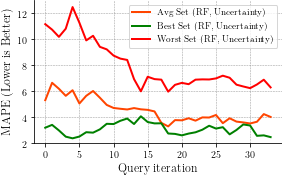

In [40]:
plot_scores(scores_avg,scores_best,scores_worst, "Uncertainty Sampling", "FVC",latexify_dict,plotting_dict,True)